In [1]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/"
downloads = {"surnames_with_splits.csv.bz2": "surnames_with_splits.csv",
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# SOLUTION: Generating Surnames with a RNN

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from nlp import StepByStep, Vocabulary, mdprint
from itertools import chain

def allclose(a, b, atol=1e-4):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    return torch.allclose(a, b, atol=atol)

## Dataframes

In [3]:
surname_df = pd.read_csv("surnames_with_splits.csv").drop(["nationality_index"], axis=1)

train_df = surname_df[surname_df.split == "train"]
val_df = surname_df[surname_df.split == "val"]
test_df = surname_df[surname_df.split == "test"]

## Vocabulary

👍
Create variables:
* `nationality_vocab` as instance of `Vocabulary` filled with nationalities from `train_df`
* `surname_vocab` as instance of `Vocabulary` which is filled with all letters from all surnames in `train_df` and whose special tokens are:
    * pad_token = `.`,
    * begin token = `<`
    * end token = `>` 
    * unknown token = `@`.
* `max_surname_size` is length of the longest surname in `train_df` increases by **2** (since begin and end tokens are added to padded surname)

In [4]:
nationality_vocab = Vocabulary()
nationality_vocab.fill(train_df.nationality)

surname_vocab = Vocabulary(pad_tok=".", unk_tok="@", bgn_tok="<", end_tok=">")
surname_vocab.fill(chain(*train_df.surname))
max_surname_size = max(train_df.surname.apply(len)) + 2 # for begin and end tok

# test
assert max_surname_size == 19, f"your max_surname_size is {max_surname_size}, not 19 "
assert len(surname_vocab) == 80
assert len(nationality_vocab) == 18
assert allclose(surname_vocab.pad("johnson", 10), [1, 43, 48, 41, 47, 52, 48, 47,  2,  0])

## Splitting

👍
Make function `vectorize(split_df, surname_vocab, nationality_vocab, max_surname_size)` where 
* `split_df` - dataframe containing surname and nationality columns
* `surname_vocab` - vocabulary of surnames
* `nationality_vocab` - vocabulary of nationalities
* `max_surname_size` - maximal length of surname
which produces:
* `x` - input vector of all surnames (call method `.pad_many` on `surname_vocab`)
* `h` - hidden vector of all nationalities (call method `.vocabularize` on `nationality_vocab`)
* `y` - is made of `x` by shifting all `x` values one place to the left and filling the empty space with `surname_vocab`'s index of the pad token.
 
and returns triple `(x, h, y)` 

In [5]:
# datasets

def vectorize(split_df, surname_vocab, nationality_vocab, max_surname_size):
    pad_idx = surname_vocab[surname_vocab.pad_tok]

    x = surname_vocab.pad_many(split_df.surname, size=max_surname_size)
    x_batch_size, _ = x.shape
    
    h = nationality_vocab.vocabularize(split_df.nationality)
    
    y_pad = torch.full(size=(x_batch_size, 1), fill_value=pad_idx)
    y = torch.cat([x[:,1:], y_pad], dim=1)

    return x, h, y

item = vectorize(train_df[:1], surname_vocab, nationality_vocab, max_surname_size)
assert len(item) == 3
x, h, y = item
assert allclose(x, [[ 1, 27, 48, 53, 34, 41,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
assert allclose(h, [0])
assert allclose(y, [[ 27, 48, 53, 34, 41,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
del x, h, y, item

In [6]:
x_train, h_train, y_train = vectorize(train_df, surname_vocab, nationality_vocab, max_surname_size)        
x_val, h_val, y_val = vectorize(val_df, surname_vocab, nationality_vocab, max_surname_size)        
x_test, h_test, y_test = vectorize(test_df, surname_vocab, nationality_vocab, max_surname_size) 

## Dataset

In [7]:
class SurnameDataset(Dataset):

    def __init__(self, x_tensor, h_tensor, y_tensor):
        self.x = x_tensor
        self.h = h_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.h[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    

## Model overview

### Vocabularization

Surname

* Surname vocabulary $|V^\text{sur}| = v^\text{sur}_{size}$
* Surname $\text{surname} = \begin{bmatrix} s_1 & s_2 & ... & s_n \end{bmatrix}$
* Vocabularization of surname $\vec{x} = V^\text{sur}(\text{surname}) = \begin{bmatrix} V^\text{sur}(s_1) & V^\text{sur}(s_2) & ... & V^\text{sur}(s_n) \end{bmatrix} = \begin{bmatrix} x_1 & x_2 & ... & x_n \end{bmatrix}$

Nationality
* Nationality vocabulary $|V^\text{nat}| = v^\text{nat}_{size}$
* Nationality $\text{nationality}$

### Tensorification

* Input vector $ \vec{x} = \begin{bmatrix} x_1 & x_2 & ... & x_{n-1} & x_n \end{bmatrix} $
+ Output vector $ y = \begin{bmatrix} x_2 & x_3 & ... & x_{n-1} & 0\end{bmatrix} $ where 0 at the end is padding index.

### Forward

* Surname embedding $ E^x$ with embedding dimension $e^x_{dim}$.
* Nationality embedding $ E^h $ with embedding dimension $e^h_{dim}$.
* Embedding of the input $ \vec{e_x} = E^x(\vec{x}) $
* Embedding of the hidden $ \vec{h_x} = E^h(h) $
* Forward through RNN $ \hat{e_y} = GRU(e_x, e_h) $
* Forward through FC $ \hat{y} = FC(e_y) $

## The Model: SurnameGenerator
👍 Create `SurnameGenerator` class as RNN width following methods:

Method `__init__(self, in_num_emb, in_emb_size, h_num_emb, h_emb_size, rnn_num_layers, batch_first=True, padding_idx=0)` initializes classifier with
* `in_num_emb` - number of embeddings is $v^{sur}_{size}$
* `in_emb_size` - dimension of embedding is $e^{sur}_{dim}$
* `h_num_emb` - number of embeddings is $v^{nat}_{size}$
* `h_emb_size` - dimension of embedding is $e^{nat}_{dim}$
* `batch_first` - first dimension of RNN output is for batch
* `padding_idx` - index of pad token
* `dropout_p` - dropout after full connected layer

Crete layers according to Model overview presented in the cells above (make Dropout also as layer)

Method `forward(self, x, h=None)` for forward propagation according to **Model overview** presented in the cells above.

In [8]:
class SurnameGenerator(torch.nn.Module):
    def __init__(self, 
                 in_num_emb, in_emb_size,
                 h_num_emb, h_emb_size,
                 rnn_num_layers=1,
                 batch_first=True, padding_idx=0, dropout_p=0.25):
                 
        super(SurnameGenerator, self).__init__()

        self.batch_first = batch_first
        self.rnn_num_layers=rnn_num_layers
        self.dropout_p = dropout_p

        self.in_emb = torch.nn.Embedding(num_embeddings=in_num_emb,
                                         embedding_dim=in_emb_size,
                                         padding_idx=padding_idx)
        
        self.h_emb = torch.nn.Embedding(num_embeddings=h_num_emb,
                                        embedding_dim=h_emb_size)
        
        self.rnn = torch.nn.GRU(input_size=in_emb_size, 
                                hidden_size=h_emb_size,
                                num_layers=rnn_num_layers,
                                batch_first=batch_first)
        
        self.fc = torch.nn.Linear(h_emb_size, in_num_emb)
        self.drop = torch.nn.Dropout(p=dropout_p)



    def forward(self, x, h=None):
        x_emb = self.in_emb(x)
        
        # repeat nationality tensor by the number of rnn layers
        h_emb = self.h_emb(h).repeat((self.rnn_num_layers, 1, 1)) if h is not None else None
        
        y_emb, last_hidden = self.rnn(x_emb, h_emb)

        y_hat = self.fc(y_emb)
        y_hat = self.drop(y_hat)
        
        return y_hat    


# test
StepByStep.set_seed(96)
model = SurnameGenerator(in_num_emb=len(surname_vocab), in_emb_size=100,
                         h_num_emb=len(nationality_vocab), h_emb_size=64,
                         rnn_num_layers=2,
                         padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=True,
                         dropout_p=0.25)


# test init
layers = list(map(type, model.children()))
assert len(layers) == 5
assert layers.count(nn.Embedding) == 2
assert layers.count(nn.GRU) == 1
assert layers.count(nn.Linear) == 1
assert layers.count(nn.Dropout) == 1
emb_shapes = {layer.weight.shape for layer in model.children() if isinstance(layer, nn.Embedding)} 
assert emb_shapes == {(80, 100), (18, 64)}
gru = next(layer for layer in model.children() if isinstance(layer, nn.GRU))
fc = next(layer for layer in model.children() if isinstance(layer, nn.Linear))
drop = next(layer for layer in model.children() if isinstance(layer, nn.Dropout))
assert gru.weight_ih_l0.shape == (192, 100)
assert gru.weight_hh_l0.shape == (192, 64)
assert drop.p == 0.25

# test init two layers
assert gru.weight_ih_l1.shape == gru.weight_hh_l1.shape == (192, 64)
del layers, emb_shapes, gru, fc, drop

# test forward
dataset = SurnameDataset(x_train, h_train, y_train)
loader = DataLoader(dataset, batch_size=2, shuffle=False)
x, h, _ = next(iter(loader))
model.train()
y = model(x, h)
assert y.shape == (2, 19, 80)
assert allclose(y.mean(), -0.0078)
# test forward in evaluation mode
model.eval()
y_eval = model(x, h)
assert len((y == y_eval).nonzero()) == 0
assert allclose(y_eval.mean(), -0.0068)
del dataset, loader, x, h, y, y_eval, model

## Loss

Calculated by negative log loss (NLL). First prediction is softmaxed and logaritmized for each output letter in a surname. Then NLL is used to calculate loss for each letter. Finally the mean of all NLL losses for each letter in a surname is used for finall loss of the whole surname.

In [9]:
def batch_nll_loss_fn(y_hat, y):
    log_softmax_y_hat = F.log_softmax(y_hat, dim=-1)
    losses = []
    for b_y_hat, b_y in zip(log_softmax_y_hat, y):
        # NLL Loss: input = Num x Classes, target = Num
        lv = F.nll_loss(b_y_hat, b_y, ignore_index=surname_vocab[surname_vocab.pad_tok])
        losses.append(lv)
    return torch.stack(losses).mean()

# Train

Epoch: 122  train loss: 2.71541 val loss: 2.27781 lr: 1.52587890625e-08

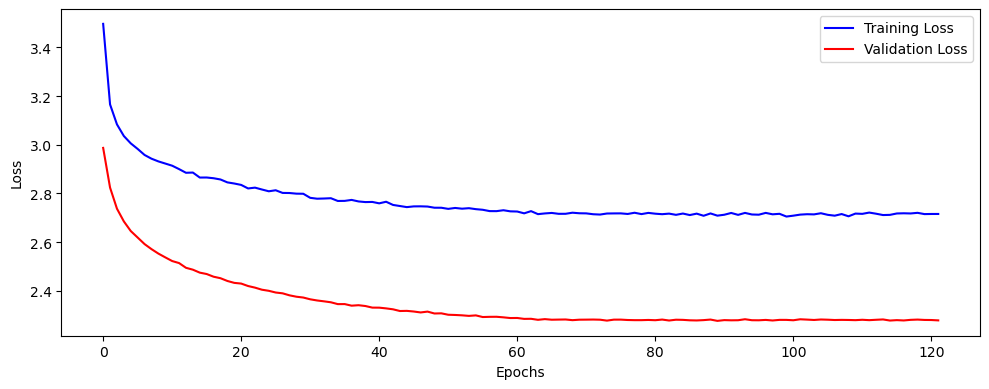

In [10]:
StepByStep.set_seed(96)

model = SurnameGenerator(in_num_emb=len(surname_vocab), in_emb_size=32,
                         h_num_emb=len(nationality_vocab), h_emb_size=16,
                         rnn_num_layers=1,
                         padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=True,
                         dropout_p=0.25)

loss_fn = batch_nll_loss_fn
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(SurnameDataset(x_train, h_train, y_train), batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(SurnameDataset(x_val, h_val, y_val), batch_size=64, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader, val_loader)

sbs.train_by_loss_change(1e-4)

sbs.plot_losses(ylog=False)


## Sampling

In [11]:
StepByStep.set_seed(96)

def generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=5):

    def generate_sample(nationality):
        h = torch.tensor([nationality_vocab[nationality]])
        sample = surname_vocab.bgn_tok
        while sample[-1] not in (surname_vocab.end_tok, surname_vocab.pad_tok) and len(sample) < max_surname_size:
            x = surname_vocab.vocabularize(sample).unsqueeze(0)
            y_hat = model(x, h)
            probs = F.softmax(y_hat[-1][-1], dim=-1).detach()
            next_char_i = torch.multinomial(probs, num_samples=1).item()
            next_char = surname_vocab.inverse[next_char_i]
            sample += next_char
            if next_char in (surname_vocab.bgn_tok, surname_vocab.end_tok) :
                break
        return sample.strip(surname_vocab.bgn_tok + surname_vocab.end_tok + surname_vocab.pad_tok)
    
    model.eval()
    for nationality in nationality_vocab:
        print(nationality)
        for _ in range(num_samples):
            sample = generate_sample(nationality)
            print(f" - {sample}")

generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=3)

Arabic
 - Gromtes
 - Kujbab
 - Dalaha
Chinese
 - QCan
 - Sen
 - Guko
Czech
 - Hgoklicon
 - Marrsz
 - Spe
Dutch
 - Ecrdeitcheved
 - Brich
 - Pirsky
English
 - Nattier
 - Suplibeflmy
 - Perbon
French
 - Grazolise
 - DünVter
 - Ry
German
 - Foll
 - Prbipernox
 - Obmosmon
Greek
 - NAcda
 - Toluavin
 - PakMonda
Irish
 - Agurmin
 - Dinyit
 - SoMerche
Italian
 - Bubiz
 - igemaupe
 - Rer
Japanese
 - Avob
 - Na
 - Utiu
Korean
 - Ke
 - Tui
 - Kois
Polish
 - Umkaiech
 - Lavingi
 - ilehsa
Portuguese
 - Igbii
 - Shandy
 - Gastelo
Russian
 - Juroov
 - Nillaristev
 - Dav
Scottish
 - Sshell
 - AchrinénfchrenSDa
 - Krriakn
Spanish
 - M
 - Rato
 - Áigeoclebo
Vietnamese
 - Lensa
 - La
 - Dey
